NAME: NIFLA M.N.F.                 
INDEX NO: 190413D             
EXERCISE 09

In [1]:
pip install opencv-contrib-python

  Using cached opencv_contrib_python-4.5.5.64-cp36-abi3-win_amd64.whl (42.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import cv2 as cv

f = open(r'./Images/templeSparseRing/templeSR_par.txt', 'r')
assert f is not None

n = int(f.readline())
l = f.readline().split()
im1_fn = l[0]

K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

# Reading info on the second image
l = f.readline().split()
im2_fn = l[0]
K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

# Read the two images and show
im1 = cv.imread(r'Images/templeSparseRing/'+im1_fn, cv.IMREAD_COLOR)
im2 = cv.imread(r'Images/templeSparseRing/'+im2_fn, cv.IMREAD_COLOR)
assert im1 is not None
assert im2 is not None

# cv.namedWindow('Im')
# cv.imshow('Im', im1)
# cv.waitKey(0)
# cv.imshow('Im', im2)
# cv.waitKey(0)
# cv.destroyAllWindows()

In [12]:
sift = cv.SIFT_create()
kp1 , desc1 = sift.detectAndCompute(im1, None)
kp2 , desc2 = sift.detectAndCompute(im1, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm =FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 100)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc1, desc2, k=2)

good = []
pts1 = []
pts2 = []
for i, (m,n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.queryIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)

F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

E = K2.T @ F @ K1
retval, R, t, mask = cv.recoverPose(E, pts1, pts2, K1)

R_t_1 = np.concatenate((R1, t1 ), axis=1) # 3 x 4
R_t_2 = np.empty((3,4))
R2_ = R1 @ R
t2_ = R1 @ t
R_t_2 = np.concatenate((R2_, t2_ ), axis=1) # 3 x 4

P2_ = K2 @ R_t_2 

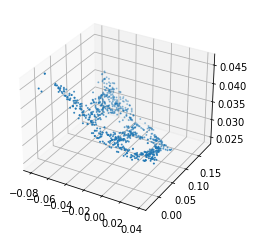

In [15]:
P1 = K1 @ np.hstack((R1,t1))
P2 = K2 @ np.hstack((R2,t2)) # P=k+[R|t]
points4d = cv.triangulatePoints(P1, P2, pts1.T, pts2.T)
points4d /= points4d[3,:]
import matplotlib.pyplot as plt
X = points4d[0,:]
Y = points4d[1,:]
Z = points4d[2,:]

fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X,Y,Z, s=1, cmap='gray')
plt.show()
